##Data preprocessing & cleaning

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=c6b79bdc966fd724a10c4c46385c087f73fe6fc4a7e7c1c213c78827e5ac999e
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


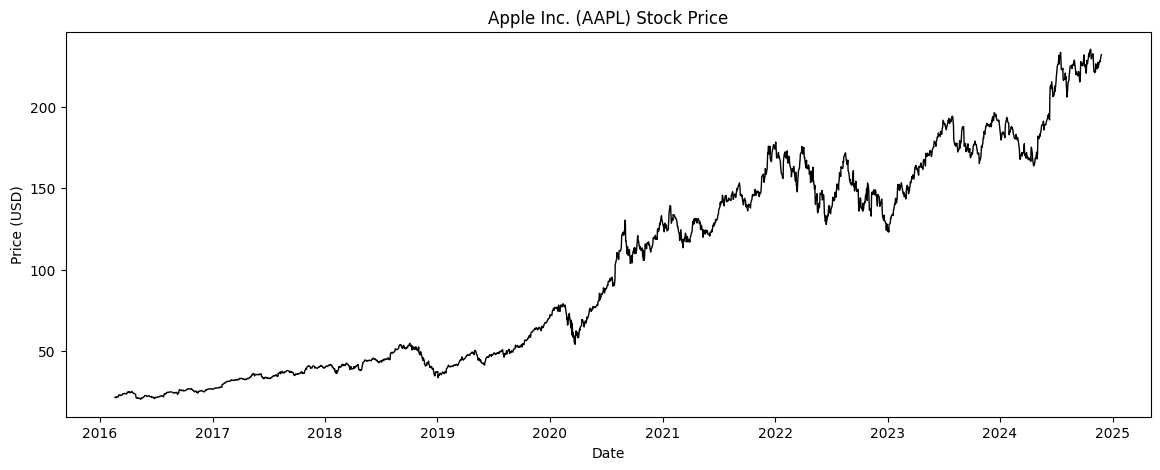

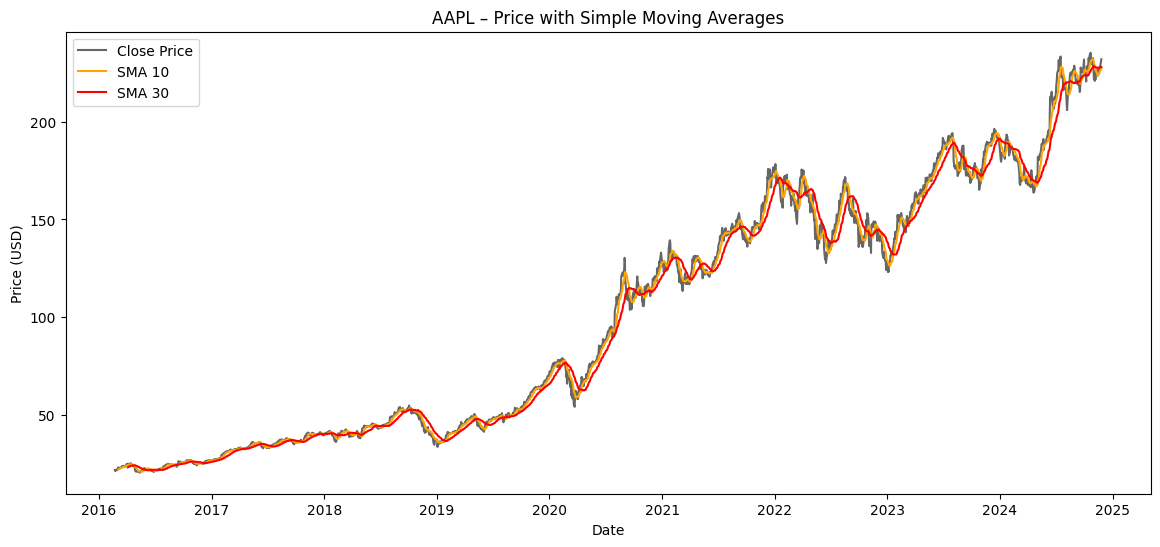

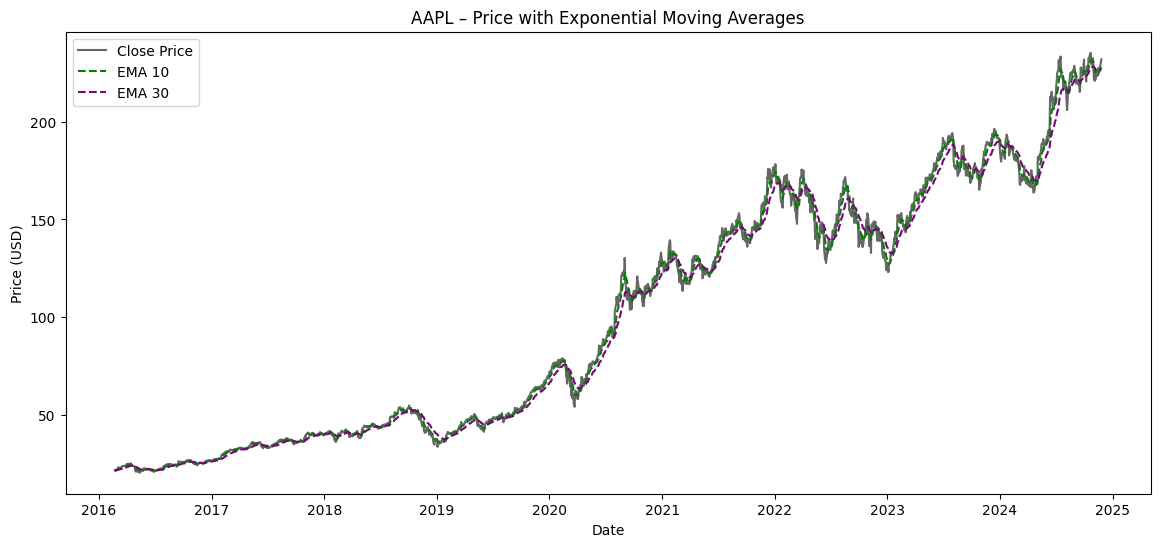

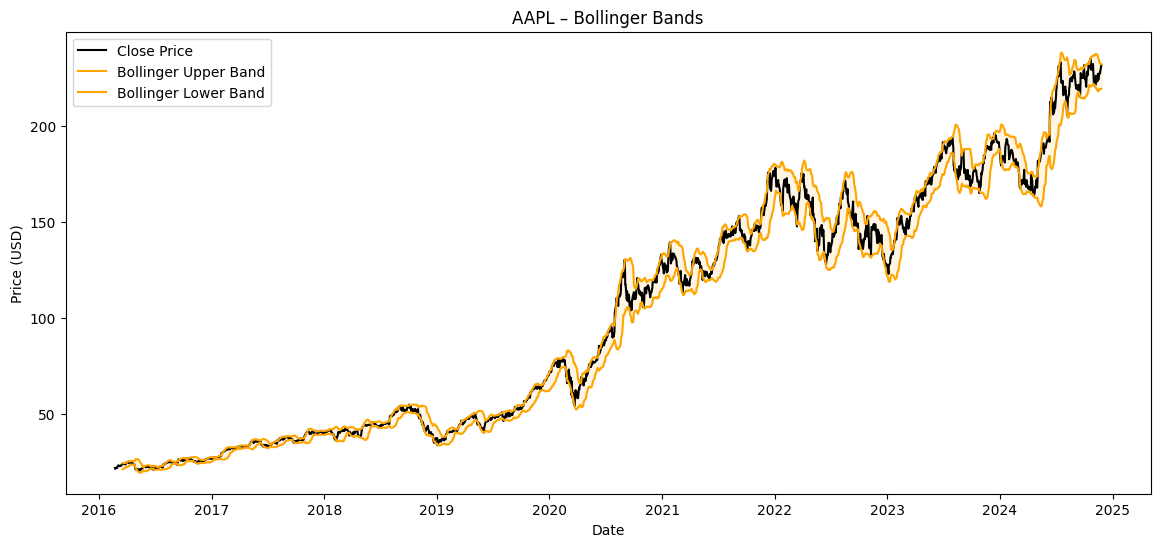

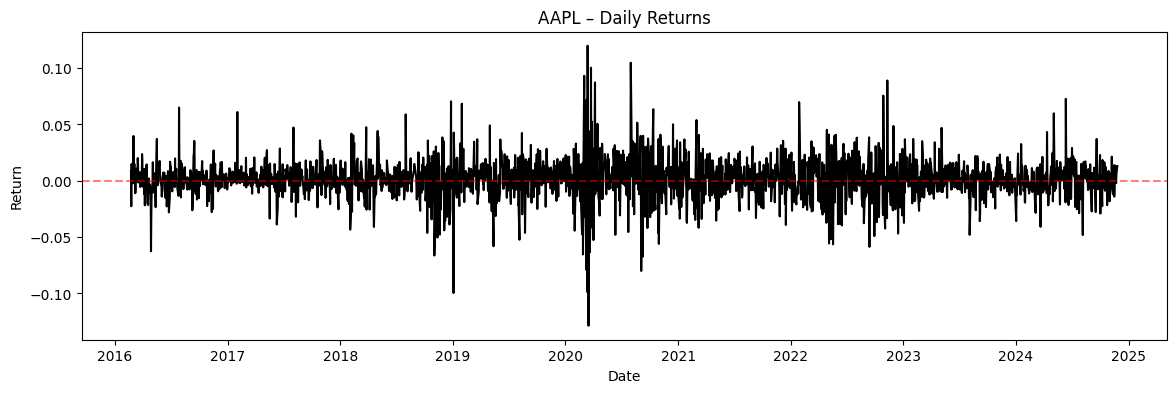

                       Date       Open       High        Low      Close  \
1 2016-02-22 00:00:00-05:00  21.832740  21.966489  21.744330  21.961954   
2 2016-02-23 00:00:00-05:00  21.853147  21.875816  21.433767  21.465504   
3 2016-02-24 00:00:00-05:00  21.304558  21.848618  21.154940  21.785145   
4 2016-02-25 00:00:00-05:00  21.773806  21.934757  21.592451  21.934757   
5 2016-02-26 00:00:00-05:00  22.034497  22.220385  21.893949  21.968758   

      Volume    Return  SMA_10  SMA_30     EMA_10     EMA_30  BB_high  BB_low  
1  137123200  0.008746     NaN     NaN  21.961954  21.961954      NaN     NaN  
2  127770400 -0.022605     NaN     NaN  21.871690  21.929925      NaN     NaN  
3  145022800  0.014891     NaN     NaN  21.855955  21.920584      NaN     NaN  
4  110330800  0.006868     NaN     NaN  21.870283  21.921499      NaN     NaN  
5  115964400  0.001550     NaN     NaN  21.888187  21.924548      NaN     NaN  


In [2]:
!pip install ta
# Import  libraries
# Import libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import ta

# Download Apple stock data
ticker = yf.Ticker("AAPL")
df = ticker.history(start="2016-02-19", end="2024-11-26")
df.reset_index(inplace=True)

# Data cleaning
df.dropna(inplace=True)
df.sort_values("Date", inplace=True)
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# =========================
# Price trend plot (STATIC)
# =========================
plt.figure(figsize=(14,5))
plt.plot(df['Date'], df['Close'], color='black', linewidth=1)
plt.title('Apple Inc. (AAPL) Stock Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

# =========================
# Daily returns
# =========================
df['Return'] = df['Close'].pct_change()
df.dropna(inplace=True)

# =========================
# Feature engineering
# =========================
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_30'] = df['Close'].rolling(window=30).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()

bb = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
df['BB_high'] = bb.bollinger_hband()
df['BB_low'] = bb.bollinger_lband()

# =========================
# SMA plot
# =========================
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='black', alpha=0.6)
plt.plot(df['Date'], df['SMA_10'], label='SMA 10', color='orange')
plt.plot(df['Date'], df['SMA_30'], label='SMA 30', color='red')
plt.title("AAPL – Price with Simple Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# =========================
# EMA plot
# =========================
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='black', alpha=0.6)
plt.plot(df['Date'], df['EMA_10'], label='EMA 10', linestyle='--', color='green')
plt.plot(df['Date'], df['EMA_30'], label='EMA 30', linestyle='--', color='purple')
plt.title("AAPL – Price with Exponential Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# =========================
# Bollinger Bands plot
# =========================
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='black')
plt.plot(df['Date'], df['BB_high'], label='Bollinger Upper Band', color='orange')
plt.plot(df['Date'], df['BB_low'], label='Bollinger Lower Band', color='orange')
plt.fill_between(df['Date'], df['BB_low'], df['BB_high'], color='orange', alpha=0.1)
plt.title("AAPL – Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# =========================
# Daily returns plot
# =========================
plt.figure(figsize=(14,4))
plt.plot(df['Date'], df['Return'], color='black')
plt.axhline(0, linestyle='--', color='red', alpha=0.5)
plt.title("AAPL – Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.show()

# Preview data
print(df.head())



This is our starting dataset.

https://www.kaggle.com/datasets/frankossai/apple-stock-aapl-historical-financial-news-data

"Apple Stock (AAPL): Historical Financial News Data is a comprehensive dataset spanning nearly nine years, from February 19, 2016, to November 27, 2024, capturing detailed information about financial news articles related to Apple Inc. (AAPL). It contains 29,752 entries, each representing a unique news article with associated metadata, sentiment analysis, and relevance to Apple stock."

This dataset already has a sentiment analysis column, but there are no details on how it was done, so using the texts of the 'cleaned' articles we will perform our own using FinBERT.



Let's load it up and do some cleaning for our encoder.

In [ ]:
import pandas as pd
from google.colab import files
from datetime import datetime
import re

# Load the file
df = pd.read_csv('/content/apple_news_data.csv')
print(f"Found {len(df)} total news articles")

# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date']).dt.tz_convert(None)
cutoff_date = datetime(2024, 11, 26)
df_filtered = df[df['date'] <= cutoff_date].copy()

# Select only the date and content columns (renamed to text)
df_clean = df_filtered[['date', 'content']].rename(columns={'content': 'text'})

# Clean the text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)  # Remove URLs and mentions
    text = re.sub(r"[^a-zA-Z\s.,!?]", "", text)  # Keep basic punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

df_clean['text'] = df_clean['text'].apply(clean_text)

# Remove rows with empty or very short text
df_clean = df_clean[df_clean['text'].str.len() >= 50]

# Format the date as a string YYYY-MM-DD (without time)
df_clean['date'] = df_clean['date'].dt.strftime('%Y-%m-%d')

# Display a preview
print(f"Rows retained after filtering and cleaning: {len(df_clean)}")
display(df_clean.head())

# Save the result
clean_filename = 'apple_news_2024_cleaned.csv'
df_clean.to_csv(clean_filename, index=False)
files.download(clean_filename)
print("\n Analysis completed! File saved as:", clean_filename)


Found 29752 total news articles
Rows retained after filtering and cleaning: 29567


,date,text
2,2024-11-26,"Could Investing , in Apple Make You a Milliona..."
6,2024-11-24,The election is leading to a return of persona...
7,2024-11-23,Warren Buffett Unloaded More Apple Shares in Q...
8,2024-11-23,Warren Buffett still holds a massive stake in ...
9,2024-11-23,Apple Intelligence is just the companys latest...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Analysis completed! File saved as: apple_news_2024_cleaned.csv


*RoBERTa* is effective at capturing informal language, irony, and slang typically found in Twitter data. FinBERT, instead, is specifically designed to recognize finance-related terminology and market-specific expressions. Since our model focuses exclusively on news articles rather than social media content, FinBERT is more appropriate due to its domain adaptation to the financial context. Previous studies have shown that these models perform well on Twitter data, and that the previously mentioned domain adaptation is crucial for achieving accurate and robust sentiment analysis results

Found 29567 total news articles


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]


Sentiment Analysis:   1%|          | 10/924 [00:09<12:59,  1.17it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

Sentiment Analysis: 100%|██████████| 924/924 [10:55<00:00,  1.41it/s]



=== Final Statistics ===
Processed news articles: 29567

Categorical distribution:
sentiment_label
neutral     46.4%
negative    32.6%
positive    21.0%
Name: proportion, dtype: object

Continuous sentiment statistics:
Mean: 0.255
Min: -0.976
Max: 0.961

=== Daily Average Sentiment Preview ===
        date  daily_avg_sentiment
0 2016-02-19             0.762293
1 2017-10-05             0.934046
2 2017-11-27             0.944135
3 2017-11-30             0.834012
4 2018-01-31             0.944467


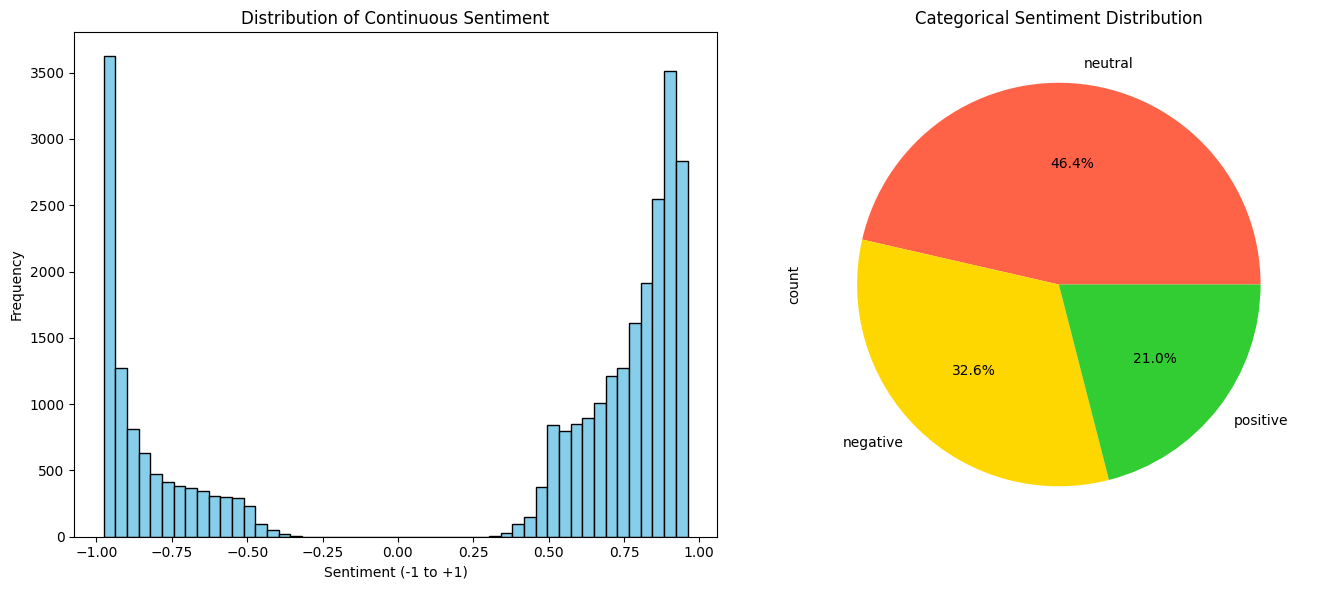

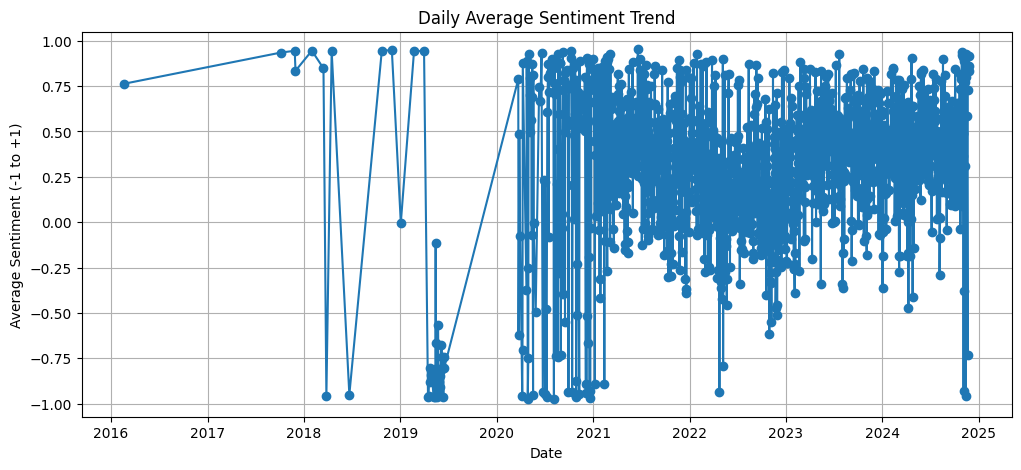


Analysis completed! Files saved as: news_until_2024-11-26.csv and daily_sentiment_avg.csv


In [ ]:
#  Load Data
import pandas as pd
from tqdm import tqdm
import torch

# Load the news dataset
df = pd.read_csv('/content/apple_news_2024_cleaned.csv')
print(f"Found {len(df)} total news articles")

#  FinBERT Model Setup
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device,
    truncation=True,
    max_length=512
)

# Sentiment Analysis
def analyze_all_texts(text_list, batch_size=32):
    results = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Sentiment Analysis"):
        batch = text_list[i:i + batch_size]
        try:
            batch_results = sentiment_pipeline(batch)
            results.extend(batch_results)
        except Exception as e:
            print(f"\nError in batch {i}-{i+batch_size}: {str(e)}")
            results.extend([{'label': 'neutral', 'score': 1.0}] * len(batch))
    return results

news_list = df['text'].astype(str).tolist()  # Use 'text' column
sentiment_results = analyze_all_texts(news_list)

# Convert Labels to Continuous Values
def convert_to_continuous(label, score):
    if label.lower() == 'negative':
        return -score
    elif label.lower() == 'positive':
        return score
    else:  # neutral
        return score

df['sentiment_label'] = [res['label'] for res in sentiment_results]
df['sentiment_score'] = [res['score'] for res in sentiment_results]
df['sentiment_continuous'] = df.apply(
    lambda x: convert_to_continuous(x['sentiment_label'], x['sentiment_score']),
    axis=1
)

# Summary Statistics
print("\n=== Final Statistics ===")
print(f"Processed news articles: {len(df)}")
print("\nCategorical distribution:")
print(df['sentiment_label'].value_counts(normalize=True).map("{:.1%}".format))
print("\nContinuous sentiment statistics:")
print(f"Mean: {df['sentiment_continuous'].mean():.3f}")
print(f"Min: {df['sentiment_continuous'].min():.3f}")
print(f"Max: {df['sentiment_continuous'].max():.3f}")

# Daily Average Sentiment
df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' column is datetime
daily_sentiment = df.groupby('date')['sentiment_continuous'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment_continuous': 'daily_avg_sentiment'}, inplace=True)

print("\n=== Daily Average Sentiment Preview ===")
print(daily_sentiment.head())

# Save daily averages
daily_output_file = "daily_sentiment_avg.csv"
daily_sentiment.to_csv(daily_output_file, index=False)

# Visualization
import matplotlib.pyplot as plt

# Histogram of continuous values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(df['sentiment_continuous'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Continuous Sentiment')
plt.xlabel('Sentiment (-1 to +1)')
plt.ylabel('Frequency')

# Pie chart of categorical labels
plt.subplot(1, 2, 2)
df['sentiment_label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['tomato', 'gold', 'limegreen']
)
plt.title('Categorical Sentiment Distribution')
plt.tight_layout()
plt.show()

# Line chart of daily average sentiment
plt.figure(figsize=(12,5))
plt.plot(daily_sentiment['date'], daily_sentiment['daily_avg_sentiment'], marker='o')
plt.title('Daily Average Sentiment Trend')
plt.xlabel('Date')
plt.ylabel('Average Sentiment (-1 to +1)')
plt.grid(True)
plt.show()

# Save Full Dataset
output_file = "news_until_2024-11-26.csv"
df.to_csv(output_file, index=False)

print("\nAnalysis completed! Files saved as:", output_file, "and", daily_output_file)


It is to be noted that the distribution of continous sentiment is in line with historic/economic period that we chose, i.e. that of Covid.

In [ ]:
import pandas as pd

# Load the full news dataset
df_new = pd.read_csv('news_until_2024-11-26.csv')

# Save a “bare” version (without article titles or content, only sentiment scores)
df_new.drop(columns=['text', 'sentiment_label', 'sentiment_score']).to_csv(
    "news_da_2016-02-19_fino_2024-11-26_bare.csv", index=False
)

# Note: "bare" here is an artistic way of saying the file contains only sentiment data, without article titles or content.


In [ ]:
df_news = pd.read_csv('/content/news_da_2016-02-19_fino_2024-11-26_bare.csv')
df_news = df_news.rename(columns={'date': 'Date'})


We rename the column to facilitate merging with the df we get from yfinance, with its own indicators and perform some feature engineering.

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Download market data
ticker = 'AAPL'
df = yf.download(ticker, start="2016-02-19", end="2024-11-26")
if isinstance(df.columns, pd.MultiIndex):
   df.columns = [col[0] for col in df.columns]

# Keep only Close and Volume
df = df[["Close", "Volume"]]

# Feature engineering
df['Return'] = df['Close'].pct_change()
df['MA_10'] = df['Close'].rolling(10, min_periods=1).mean()
df['MA_30'] = df['Close'].rolling(30, min_periods=1).mean()
df['Price_Change'] = df['Close'].pct_change()
df['MA_Diff'] = df['MA_10'] - df['MA_30']

# EMA_10 and EMA_30
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()

df['EMA_Diff'] = df['EMA_10'] - df['EMA_30']

# Calculate Bollinger Bands
window = 20
df['BB_middle'] = df['Close'].rolling(window=window).mean()
df['BB_std'] = df['Close'].rolling(window=window).std()
df['BB_high'] = df['BB_middle'] + (df['BB_std'] * 2)
df['BB_low'] = df['BB_middle'] - (df['BB_std'] * 2)

df['BB_Position'] = (df['Close'] - df['BB_low']) / (df['BB_high'] - df['BB_low'])
df['Volume_MA'] = df['Volume'] / df['Volume'].rolling(5).mean()
df['Volatility'] = df['Return'].rolling(window=10).std()
df['Momentum_5d'] = df['Close'] / df['Close'].shift(5) - 1

# Target = next day return
df['Target'] = df['Return'].shift(-1)

df = df.reset_index()

# Convert 'Date' column in df_news to datetime to match df
df_news['Date'] = pd.to_datetime(df_news['Date'])

df = df.merge(
    df_news,
    on='Date',
    how='left'
)


/tmp/ipython-input-3977144241.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2016-02-19", end="2024-11-26")
[*********************100%***********************]  1 of 1 completed


Let's eliminate the period where some features are missing.

In [ ]:
# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

#Let's remove data with missing values
df = df[df['Date'] > '2020-03-23'].reset_index(drop=True)

# Filter out rows where 'Date' falls within the specified range
df = df[~((df['Date'] >= start_date_to_remove) & (df['Date'] <= end_date_to_remove))]

# Filter out rows where 'sentiment_continuous' is NaN
df = df.dropna(subset=['sentiment_continuous'])

# Reset the index of the DataFrame after filtering
df = df.reset_index(drop=True)


##Dataframe for classification

In [ ]:
future_return_3d = df['Close'].pct_change(3).shift(-3)
future_return_5d = df['Close'].pct_change(5).shift(-5)

condition1 = future_return_3d > future_return_3d.quantile(0.6)
condition2 = future_return_5d > 0
condition3 = df['Volume'] > df['Volume'].rolling(20).mean()

df['Target'] = ((condition1 & condition2) | (condition1 & condition3)).astype(int)

In [ ]:
df

,Date,Close,Volume,Return,MA_10,MA_30,Price_Change,MA_Diff,EMA_10,EMA_30,...,BB_middle,BB_std,BB_high,BB_low,BB_Position,Volume_MA,Volatility,Momentum_5d,Target,sentiment_continuous
0,2017-11-27,40.770466,82867200,-0.005030,40.346105,39.134782,-0.005030,1.211323,40.451604,39.385934,...,40.238351,0.724619,41.687588,38.789114,0.683584,1.018264,0.010923,0.023156,1,0.944135
1,2017-11-30,40.245876,166108800,0.013984,40.346340,39.415889,0.013984,0.930451,40.310762,39.524500,...,40.397023,0.551424,41.499872,39.294174,0.431475,1.438262,0.011961,-0.017776,0,0.834012
2,2018-01-31,39.210747,129915600,0.002755,40.537675,40.678500,0.002755,-0.140825,40.135135,40.466159,...,40.771045,0.860776,42.492597,39.049492,0.046834,0.773899,0.008756,-0.038973,1,0.944467
3,2018-03-16,41.860809,157618800,-0.003526,41.908781,40.347903,-0.003526,1.560878,41.863233,41.073718,...,41.530195,0.690061,42.910318,40.150073,0.619777,1.267705,0.009275,-0.010890,1,0.847240
4,2018-03-27,39.584595,163690400,-0.025641,40.723173,41.022828,-0.025641,-0.299655,40.467028,40.722117,...,41.248020,1.007782,43.263584,39.232456,0.087355,1.033199,0.021246,-0.039375,0,-0.959895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26421,2024-11-15,223.986969,47923700,-0.014109,223.831235,227.375330,-0.014109,-3.544095,224.877318,225.906321,...,226.822433,4.448572,235.719576,217.925289,0.340653,1.070597,0.010875,-0.008636,1,0.916951
26422,2024-11-19,227.252197,36211800,0.001140,224.959088,227.684987,0.001140,-2.725899,225.623898,226.058759,...,226.049882,3.518855,233.087592,219.012172,0.585420,0.814630,0.011285,0.018062,0,-0.730230
26423,2024-11-20,227.968948,35169600,0.003154,225.608626,227.675439,0.003154,-2.066813,226.050271,226.181997,...,225.974901,3.457619,232.890138,219.059663,0.644178,0.841931,0.011114,0.017235,0,0.730671
26424,2024-11-22,228.835037,38168300,0.005908,226.026735,227.751820,0.005908,-1.725085,226.770933,226.432172,...,225.821479,3.317376,232.456230,219.186728,0.727104,0.972234,0.009205,0.021644,0,0.817710


In [ ]:
from google.colab import files

filename = 'df_with_indicators_classification.csv'
df.to_csv(filename, index=False)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##LSTM Classification Model


We first note that the target is not a simple binary “Will the stock go up or not?” A 0.1% increase in the stock price would count as a “success” for the model, but it would not generate profit in practice, as trading costs would cancel out any gains. Therefore, we define a significant upward movement as being above the 60th percentile.
We construct features that capture trend, momentum, volatility, volume, and market sentiment. The data is cleaned using interpolation, and the most important features are selected via Random Forest to reduce noise and model complexity. Features are then scaled and organized into 20-day temporal sequences to capture dynamic patterns.
The dataset is split temporally into training, validation, and test sets. We use Conv1D layers to detect local patterns and technical microstructures, and Bidirectional LSTM layers to learn temporal dependencies and market context. The model is trained to maximize meaningful performance metrics, employing early stopping and adaptive learning rates to ensure robust learning.

Class weights: {np.int64(0): np.float64(0.5509117483296214), np.int64(1): np.float64(5.410457963089542)}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │        36,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,993 (222.63 KB)

 Trainable params: 56,993 (222.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
495/495 ━━━━━━━━━━━━━━━━━━━━ 155s 235ms/step - loss: 0.6808 - pr_auc: 0.1637 - roc_auc: 0.6086 - val_loss: 0.5822 - val_pr_auc: 0.1691 - val_roc_auc: 0.6619
Epoch 2/80
495/495 ━━━━━━━━━━━━━━━━━━━━ 79s 108ms/step - loss: 0.6083 - pr_auc: 0.2427 - roc_auc: 0.7193 - val_loss: 0.5711 - val_pr_auc: 0.1916 - val_roc_auc: 0.6910
Epoch 3/80
495/495 ━━━━━━━━━━━━━━━━━━━━ 61s 124ms/step - loss: 0.5809 - pr_auc: 0.2614 - roc_auc: 0.7480 - val_loss: 0.5149 - val_pr_auc: 0.1743 - val_roc_auc: 0.6788
Epoch 4/80
495/495 ━━━━━━━━━━━━━━━━━━━━ 73s 105ms/step - loss: 0.5680 - pr_auc: 0.2707 - roc_auc: 0.7590 - val_loss: 0.5457 - val_pr_auc: 0.1770 - val_roc_auc: 0.6886
Epoch 5/80
495/495 ━━━━━━━━━━━━━━━━━━━━ 55s 111ms/step - loss: 0.5617 - pr_auc: 0.2791 - roc_auc: 0.7630 - val_loss: 0.5236 - val_pr_auc: 0.1735 - val_roc_auc: 0.6873
Epoch 6/80
495/495 ━━━━━━━━━━━━━━━━━━━━ 81s 109ms/step - loss: 0.5568 - pr_auc: 0.2795 - roc_auc: 0.7672 - val_loss: 0.5242 - val_pr_auc: 0.1679 - val_roc_auc: 0.68

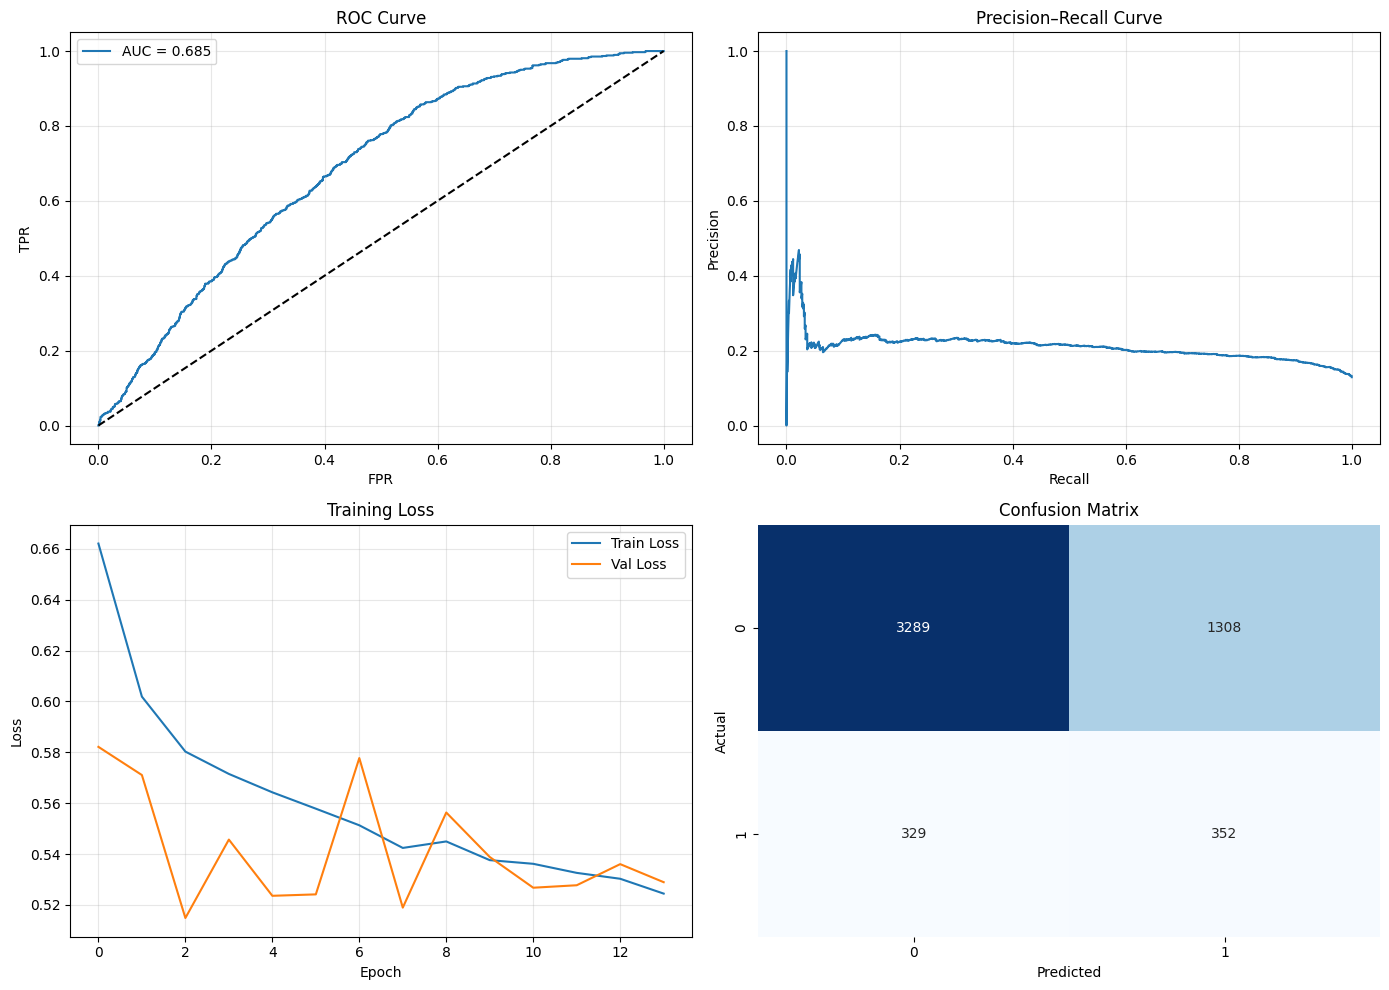

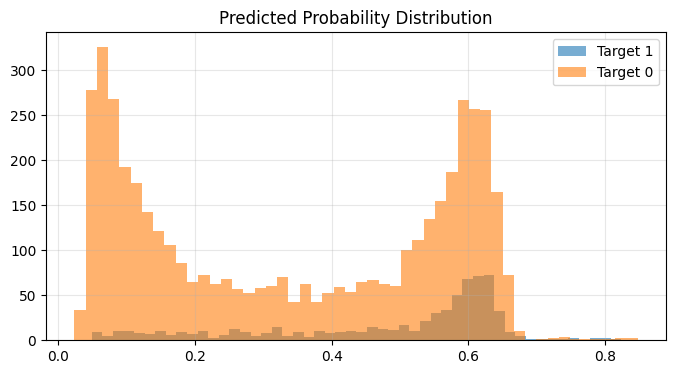

In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, precision_recall_curve, roc_curve,
    f1_score
)
from sklearn.utils.class_weight import compute_class_weight

#Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#Load & feature engineering
df = pd.read_csv('/content/df_with_indicators_classification.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df['Return_1d'] = df['Close'].pct_change()
df['Return_5d'] = df['Close'].pct_change(5)
df['Volatility_10d'] = df['Return_1d'].rolling(10).std()
df['Momentum_10d'] = df['Close'] / df['Close'].shift(10) - 1
df['Volume_MA_10'] = df['Volume'] / df['Volume'].rolling(10).mean()

future_return_5d = df['Close'].pct_change(5).shift(-5)
df['Target'] = (future_return_5d > 0).astype(int)

features = [
    'Return_1d',
    'Return_5d',
    'Volatility_10d',
    'Momentum_10d',
    'Volume_MA_10',
    'sentiment_continuous'
]

df = df.dropna(subset=features + ['Target']).reset_index(drop=True)


#Sequence building
SEQ_LEN = 30

X_all = df[features].values
y_all = df['Target'].values

X_seq, y_seq = [], []
for i in range(SEQ_LEN, len(X_all)):
    X_seq.append(X_all[i-SEQ_LEN:i])
    y_seq.append(y_all[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

#Time-based split
n = len(X_seq)
train_end = int(0.6 * n)
val_end   = int(0.8 * n)

X_train, y_train = X_seq[:train_end], y_seq[:train_end]
X_val, y_val     = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test, y_test   = X_seq[val_end:], y_seq[val_end:]


#Scaling (train only)
scaler = StandardScaler()

X_train_2d = X_train.reshape(-1, X_train.shape[-1])
X_val_2d   = X_val.reshape(-1, X_val.shape[-1])
X_test_2d  = X_test.reshape(-1, X_test.shape[-1])

scaler.fit(X_train_2d)

X_train = scaler.transform(X_train_2d).reshape(X_train.shape)
X_val   = scaler.transform(X_val_2d).reshape(X_val.shape)
X_test  = scaler.transform(X_test_2d).reshape(X_test.shape)

#Class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight = dict(zip(classes, class_weights))
print("Class weights:", class_weight)


#Model
model = Sequential([
    tf.keras.layers.Input(shape=(SEQ_LEN, X_train.shape[2])),

    Bidirectional(
        LSTM(
            64,
            return_sequences=True,
            dropout=0.2,
            recurrent_dropout=0.1,
            kernel_regularizer=regularizers.l2(1e-4)
        )
    ),

    LSTM(
        32,
        dropout=0.2,
        recurrent_dropout=0.1,
        kernel_regularizer=regularizers.l2(1e-4)
    ),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='roc_auc'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR')
    ]
)

model.summary()


#Training
early_stop = EarlyStopping(
    monitor='val_pr_auc',
    patience=12,
    restore_best_weights=True,
    mode='max'
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=1
)

#Threshold optimization
y_val_proba = model.predict(X_val).ravel()

thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = [
    f1_score(y_val, (y_val_proba > t).astype(int))
    for t in thresholds
]

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best decision threshold: {best_threshold:.3f}")


#Test evaluation
y_test_proba = model.predict(X_test).ravel()
y_test_pred = (y_test_proba > best_threshold).astype(int)

print(classification_report(y_test, y_test_pred, digits=4))

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"Test ROC AUC: {roc_auc:.4f}")

#Plots
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(recall, precision)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(2, 2, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

#Probability distribution
plt.figure(figsize=(8,4))
plt.hist(y_test_proba[y_test==1], bins=50, alpha=0.6, label='Target 1')
plt.hist(y_test_proba[y_test==0], bins=50, alpha=0.6, label='Target 0')
plt.legend()
plt.title("Predicted Probability Distribution")
plt.grid(alpha=0.3)
plt.show()

The model exhibits a measurable ability to extract signal from highly noisy financial time series. The predictive performance, as reflected by a ROC AUC of approximately 0.68, indicates the presence of a modest but non-random edge, suggesting that the model discriminates meaningfully better than chance, though with limited separation power. The recall of approximately 52% for the positive class shows that the model successfully identifies slightly more than half of the true upward-move opportunities, however, the corresponding precision of roughly 21% highlights a significant level of noise in the generated signals, with a substantial proportion of false positives. In other words, the model correctly identifies almost one opportunity out of two (as reflected by the 52% recall), but does so at the cost of producing a large number of false positives.
This trade-off suggests that while the model is capable of identifying directional regimes, it lacks sufficient confidence calibration to isolate high-quality trades.

# XGBoostClassifier Model

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

#!pip install --upgrade xgboost


#Load data

df = pd.read_csv("/content/df_with_indicators_classification.csv")
df = df[df['Date'] > '2020-03-23'].reset_index(drop=True)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)


#Feature engineering

df["Price_Change"] = df["Close"].pct_change()
df["MA_Diff"] = df["MA_10"] - df["MA_30"]
df["EMA_Diff"] = df["EMA_10"] - df["EMA_30"]
df["BB_Position"] = (df["Close"] - df["BB_low"]) / (df["BB_high"] - df["BB_low"])
df["Volume_MA"] = df["Volume"] / df["Volume"].rolling(5).mean()
df["Volatility"] = df["Return"].rolling(10).std()
df["Momentum_5d"] = df["Close"] / df["Close"].shift(5) - 1


#Directional target

df["Target"] = (df["Return"].shift(-1) > 0).astype(int)

df = df.dropna().reset_index(drop=True)

feature_cols = [
    "Close","Volume","MA_10","MA_30","EMA_10","EMA_30",
    "BB_low","BB_high","Price_Change","MA_Diff","EMA_Diff",
    "BB_Position","Volume_MA","Volatility","Momentum_5d",
    "sentiment_continuous"
]

X = df[feature_cols].values
y = df["Target"].values
dates = df["Date"].values


#Model and pipeline

model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric="logloss",
    random_state=42,
    tree_method="hist"
)

pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", model)
])


#Walk-forward validation

tscv = TimeSeriesSplit(n_splits=5)
oof_preds = np.zeros(len(y))
oof_probs = np.zeros(len(y))

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    callbacks = [xgb.callback.EarlyStopping(rounds=50, metric_name="logloss", data_name="validation_0")]

    pipeline.fit(
        X_train, y_train,
        model__eval_set=[(X_val, y_val)],
        model__verbose=False
    )

    oof_preds[val_idx] = pipeline.predict(X_val)
    oof_probs[val_idx] = pipeline.predict_proba(X_val)[:, 1]


#Metrics

acc = accuracy_score(y, oof_preds)
auc = roc_auc_score(y, oof_probs)

print("\nDIRECTIONAL PERFORMANCE (WALK-FORWARD)")
print(f"Accuracy : {acc:.4f}")
print(f"ROC AUC  : {auc:.4f}\n")

print(classification_report(y, oof_preds, digits=4))

#Final train (for deployment)

pipeline.fit(X, y);


DIRECTIONAL PERFORMANCE (WALK-FORWARD)
Accuracy : 0.6491
ROC AUC  : 0.6648

              precision    recall  f1-score   support

           0     0.6254    0.6640    0.6441     12612
           1     0.6735    0.6355    0.6539     13757

    accuracy                         0.6491     26369
   macro avg     0.6495    0.6497    0.6490     26369
weighted avg     0.6505    0.6491    0.6492     26369



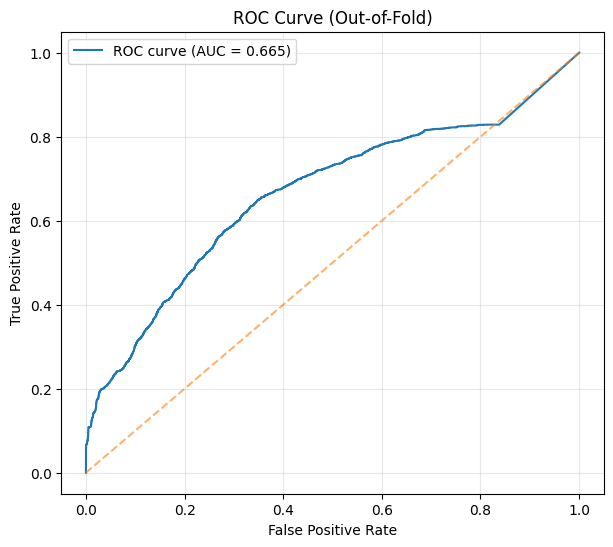

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, oof_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Out-of-Fold)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The ROC–AUC curve exhibits a steep increase at low false positive rates followed by a pronounced flattening, indicating that the model’s discriminative power is concentrated in a subset of high-confidence predictions. This suggests that informative signal is present only intermittently, while the majority of observations are effectively noisy and close to random. This is common in financial time series.

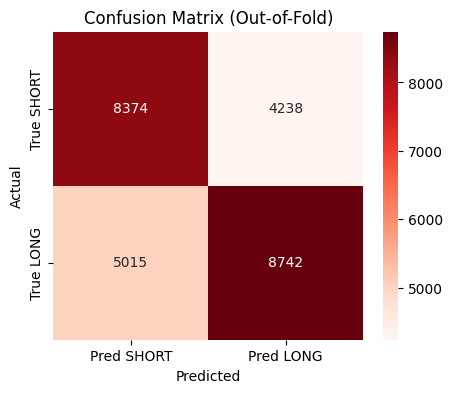

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y, oof_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Pred SHORT", "Pred LONG"],
    yticklabels=["True SHORT", "True LONG"]
)

plt.title("Confusion Matrix (Out-of-Fold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The model demonstrates a meaningful ability to extract directional signals from noisy financial time series. With a walk-forward accuracy of approximately 65% and a ROC AUC of 0.6648, the model shows a modest but statistically significant edge over random chance, indicating that it can discriminate between upward and downward moves more effectively than baseline guessing. The class-level metrics reveal a balanced performance: for the positive class, the recall of about 61% indicates that the model identifies a majority of true upward moves, while the precision of roughly 69% suggests that most of its positive predictions are correct. Conversely, the negative class shows a recall of 70% and precision of 62%, reflecting similar effectiveness in detecting downward moves. Overall, these results indicate that the model is capable of capturing directional regimes with reasonable consistency, producing predictions that are both moderately accurate and relatively well-calibrated, though not perfectly separable. We opted for this model or our next step.

#XGBoostClassifier Model + GARCH + Reject Option Learning


In [ ]:
!pip install yfinance xgboost optuna torch torchvision torchaudio scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.2 MB/s eta 0:00:00



DIRECTIONAL PERFORMANCE (WALK-FORWARD)
Accuracy : 0.6448
ROC AUC  : 0.6649

              precision    recall  f1-score   support

           0     0.6179    0.6748    0.6451     12612
           1     0.6744    0.6174    0.6446     13757

    accuracy                         0.6448     26369
   macro avg     0.6461    0.6461    0.6448     26369
weighted avg     0.6473    0.6448    0.6448     26369



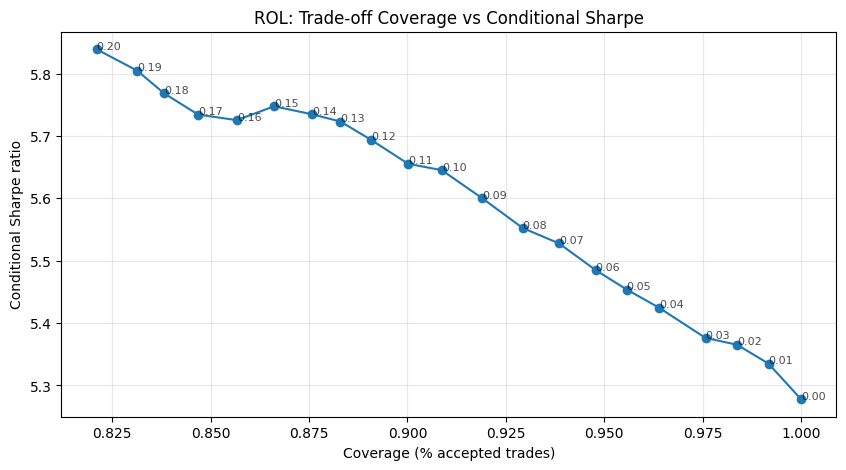

tau maximizing Sharpe: 0.200
optimal tau coverage: 82.10%
optimal tau conditional Sharpe: 5.8391
ROL coverage          : 82.10%
Conditional Accuracy  : 0.6641
Conditional AUC       : 0.6685
Conditional Sharpe    : 5.8391


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Install/Upgrade xgboost to ensure early_stopping_rounds is supported
#!pip install --upgrade xgboost # Already installed the latest version

#Load data

df = pd.read_csv("/content/df_with_indicators_classification.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Remove data from 2017 to 2020-03-23
df = df[df['Date'] > '2020-03-23'].reset_index(drop=True)

#Feature engineering

df["Price_Change"] = df["Close"].pct_change()
df["MA_Diff"] = df["MA_10"] - df["MA_30"]
df["EMA_Diff"] = df["EMA_10"] - df["EMA_30"]
df["BB_Position"] = (df["Close"] - df["BB_low"]) / (df["BB_high"] - df["BB_low"])
df["Volume_MA"] = df["Volume"] / df["Volume"].rolling(5).mean()
df["Volatility"] = df["Return"].rolling(10).std()
df["Momentum_5d"] = df["Close"] / df["Close"].shift(5) - 1

#Directional target (1 if next-day return is positive)

df["Target"] = (df["Return"].shift(-1) > 0).astype(int)

df = df.dropna().reset_index(drop=True)

feature_cols = [
    "Close","Volume","MA_10","MA_30","EMA_10","EMA_30",
    "BB_low","BB_high","Price_Change","MA_Diff","EMA_Diff",
    "BB_Position","Volume_MA","Volatility","Momentum_5d",
    "sentiment_continuous"
]

X = df[feature_cols].values
y = df["Target"].values
dates = df["Date"].values

#Model and pipeline
#we found these hyperparameters while experimenting with grid search

model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric="logloss",
    random_state=42,
    tree_method="hist"
)

pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", model)
])

#walk-forward validation

tscv = TimeSeriesSplit(n_splits=5)

#out-of-fold predictions and probabilities
oof_preds = np.zeros(len(y))
oof_probs = np.zeros(len(y))

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # xgb.callback.EarlyStopping for early stopping (without this tweak it could overfit)
    callbacks = [xgb.callback.EarlyStopping(rounds=50, metric_name="logloss", data_name="validation_0")]

    pipeline.fit(
        X_train, y_train,
        model__eval_set=[(X_val, y_val)],
        model__verbose=False
    )

    oof_preds[val_idx] = pipeline.predict(X_val)
    oof_probs[val_idx] = pipeline.predict_proba(X_val)[:, 1]

#Metrics

acc = accuracy_score(y, oof_preds)
auc = roc_auc_score(y, oof_probs)

print("\nDIRECTIONAL PERFORMANCE (WALK-FORWARD)")
print(f"Accuracy : {acc:.4f}")
print(f"ROC AUC  : {auc:.4f}\n")

print(classification_report(y, oof_preds, digits=4))

#ROL automatic scan on tau

taus = np.linspace(0.0, 0.2, 21)  # da 0 a 0.2, step 0.01
coverages = []
sharpes = []

returns = df["Return"].values

for tau in taus:
  # confidence defined as distance from 0.5 probability (in the 11. there's more options, we opted for this simple one)
    confidence = np.abs(oof_probs - 0.5)
    trade_mask = confidence >= tau

    # conditional Sharpe when trade are taken
    if trade_mask.sum() > 0:
        strategy_returns = returns[trade_mask] * (2*oof_preds[trade_mask]-1)
        sharpe = np.mean(strategy_returns) / np.std(strategy_returns) * np.sqrt(252)
    else:
        sharpe = np.nan  # no trade

    coverages.append(trade_mask.mean())
    sharpes.append(sharpe)

#Sharpe vs Coverage
plt.figure(figsize=(10,5))
plt.plot(coverages, sharpes, marker='o')
for i, tau in enumerate(taus):
    plt.text(coverages[i], sharpes[i], f"{tau:.2f}", fontsize=8, alpha=0.7)

plt.xlabel("Coverage (% accepted trades)")
plt.ylabel("Conditional Sharpe ratio")
plt.title("ROL: Trade-off Coverage vs Conditional Sharpe")
plt.grid(alpha=0.3)
plt.show()

#Optimal tau
best_idx = np.nanargmax(sharpes)
best_tau = taus[best_idx]
print(f"tau maximizing Sharpe: {best_tau:.3f}")
print(f"optimal tau coverage: {coverages[best_idx]:.2%}")
print(f"optimal tau conditional Sharpe: {sharpes[best_idx]:.4f}")

#Optimal tau after loop
tau_opt = 0.2

#Confidence and trade mask
confidence = np.abs(oof_probs - 0.5)
trade_mask = confidence >= tau_opt

#Final predictions
# -1 = reject / no trade
oof_preds_final = oof_preds.copy()
oof_preds_final[~trade_mask] = -1

#Conditional Metrics
conditional_acc = accuracy_score(y[trade_mask], oof_preds[trade_mask])
conditional_auc = roc_auc_score(y[trade_mask], oof_probs[trade_mask])
coverage = trade_mask.mean()

print(f"ROL coverage          : {coverage:.2%}")
print(f"Conditional Accuracy  : {conditional_acc:.4f}")
print(f"Conditional AUC       : {conditional_auc:.4f}")
print(f"Conditional Sharpe    : {sharpe:.4f}")
plt.show()

pipeline.fit(X, y);

Machine Learning with a Reject Option: A survey

As noted in the article mentioned (11.), traditional ML models always make a prediction, even when they may be wrong. In critical domains such as medicine, engineering, and finance, errors can have serious consequences. The reject option enables a model to improve the accuracy of accepted predictions, increase user trust, save time by delegating difficult cases to human experts, and reduce bias and unfairness in predictions.

It's also useful, we add, in order to understand quickly a model's weaknesses, so that we can compensate them with new hyperparameters, features or an ensemble. Let's try the last one, but let's visualize the situation in a clearer way:

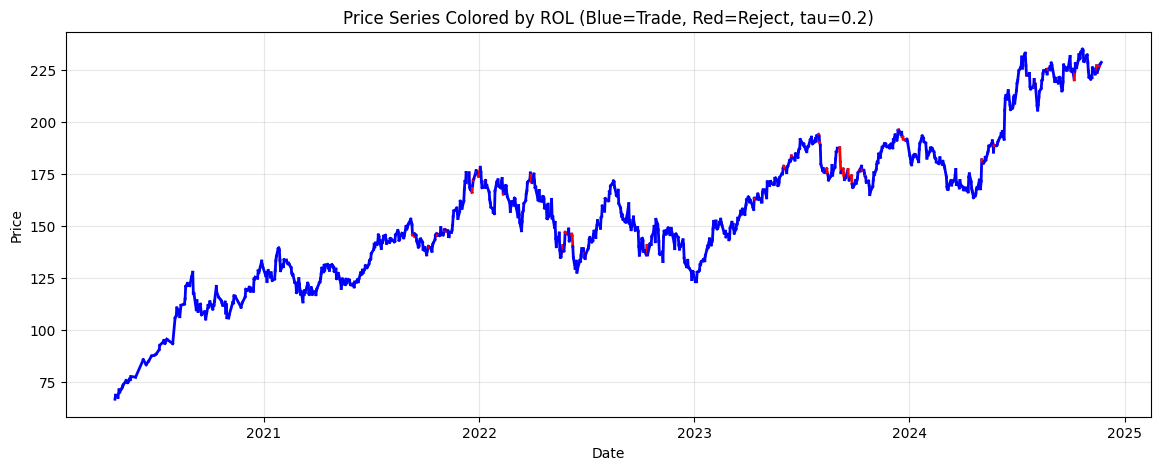

In [ ]:
import matplotlib.colors as mcolors

# Optimal tau
tau_opt = 0.2

# Confidence and trade mask
confidence = np.abs(oof_probs - 0.5)
trade_mask = confidence >= tau_opt

# Blue - accept the trade, Red - reject
colors = np.where(trade_mask, 'blue', 'red')

plt.figure(figsize=(14,5))

# Segments plot
for i in range(1, len(df)):
    plt.plot(dates[i-1:i+1], df["Close"].values[i-1:i+1],
             color=colors[i], linewidth=2)

plt.title(f"Price Series Colored by ROL (Blue=Trade, Red=Reject, tau={tau_opt})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(alpha=0.3)
plt.show()

In this graph, red dots indicate a difficulty making a prediction. We can quickly notice that this model doesn't perform well in high volatility regimes and in volatility clusterings, to improve that, we'll do an ensamble with a GARCH model, known to have less problems in those instances.

In [ ]:
!pip install arch

===== ENSEMBLE DIAGNOSTICS (PRODUCTION READY) =====
Coverage                  : 72.36%
Sharpe Ratio              : 3.833
Sortino Ratio             : 8.626
Probabilistic Sharpe Ratio: 100.00%
Max Drawdown              : -98.76%
Hit Rate                  : 60.92%
Profit Factor             : 1.69
Avg Win / Loss            : 0.0075 / -0.0069
Skew / Kurtosis           : -0.39 / 1.59
Turnover Proxy            : 0.00


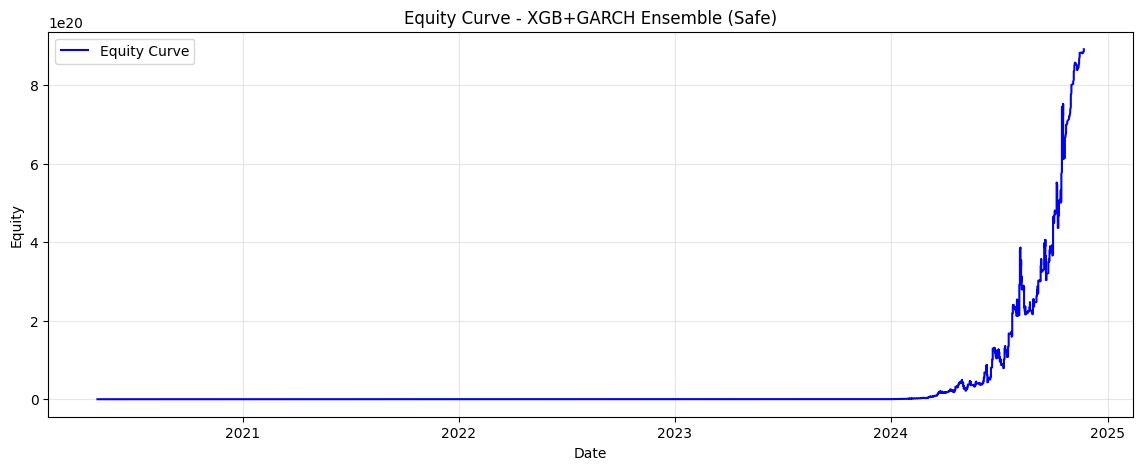

In [ ]:
import numpy as np
from arch import arch_model
from scipy.stats import norm

#Garch (1,1)
returns_pct = df["Return"] * 100
garch = arch_model(returns_pct, vol="Garch", p=1, q=1, mean="Zero")
garch_res = garch.fit(disp="off")

df["GARCH_vol"] = garch_res.conditional_volatility / 100
df["GARCH_vol_lag1"] = df["GARCH_vol"].shift(1)
df = df.dropna().reset_index(drop=True)

#Prob ensemble
vol = df["GARCH_vol_lag1"].values
vol_norm = (vol - vol.min()) / (vol.max() - vol.min())
risk_weight = np.exp(-3 * vol_norm)
p_ensemble = 0.5 + (oof_probs[-len(vol):] - 0.5) * risk_weight

#ROL
tau = 0.15
confidence = np.abs(p_ensemble - 0.5)
trade_mask = confidence >= tau
pred_signal = np.where(trade_mask, (p_ensemble > 0.5).astype(int), 0)

#High volume filter
high_risk = vol > np.percentile(vol, 90)   # ignores top 10% vol
trade_mask[high_risk] = False
pred_signal[~trade_mask] = 0

#Risk-based position sizing
risk_per_trade = 0.01   # max 1% capital per trade
max_leverage = 1.0      # leverage cap
position = (2*pred_signal-1) * np.clip(risk_per_trade / vol, 0, max_leverage)

#Strategy returns
returns = df["Return"].values
strategy_returns = position * returns
strategy_returns = np.clip(strategy_returns, -risk_per_trade, risk_per_trade)

#Equity curve
equity = np.cumprod(1 + strategy_returns)
peak = np.maximum.accumulate(equity)
drawdown = (equity - peak) / peak
max_dd = drawdown.min()

#Metrics
sr = strategy_returns[strategy_returns != 0]
mean_ret = sr.mean()
vol_ret = sr.std()
sharpe = mean_ret / vol_ret * np.sqrt(252)
downside = sr[sr < 0].std()
sortino = mean_ret / downside * np.sqrt(252)
hit_rate = (sr > 0).mean()
avg_win = sr[sr > 0].mean()
avg_loss = sr[sr < 0].mean()
profit_factor = sr[sr > 0].sum() / abs(sr[sr < 0].sum())
skew = ((sr - sr.mean())**3).mean() / (sr.std()**3)
kurt = ((sr - sr.mean())**4).mean() / (sr.std()**4)
turnover = np.mean(np.abs(np.diff(pred_signal[pred_signal != 0])))
T = len(sr)
psr = norm.cdf(sharpe / np.sqrt((1 - skew*sharpe + ((kurt-1)/4)*sharpe**2)/(T-1)))

#Statistical indicators
print("===== ENSEMBLE DIAGNOSTICS (PRODUCTION READY) =====")
print(f"Coverage                  : {trade_mask.mean():.2%}")
print(f"Sharpe Ratio              : {sharpe:.3f}")
print(f"Sortino Ratio             : {sortino:.3f}")
print(f"Probabilistic Sharpe Ratio: {psr:.2%}")
print(f"Max Drawdown              : {max_dd:.2%}")
print(f"Hit Rate                  : {hit_rate:.2%}")
print(f"Profit Factor             : {profit_factor:.2f}")
print(f"Avg Win / Loss            : {avg_win:.4f} / {avg_loss:.4f}")
print(f"Skew / Kurtosis           : {skew:.2f} / {kurt:.2f}")

#Equity curve
import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
plt.plot(df["Date"], equity, label="Equity Curve", color="blue")
plt.title("Equity Curve - XGB+GARCH Ensemble (Safe)")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


The model is predicting the market direction well, with a hit rate of 61% and profitable trades on average (Profit Factor 1.69, Avg Win 0.75% vs Avg Loss 0.69%). The strategy is very efficient for its risk, shown by a high Sharpe (3.83) and Sortino (8.63), and trades only when confident (Coverage 72%) with low turnover. However, the Max Drawdown of −98.76% indicates that early or extreme trades are too large, risking most of the capital despite the strong overall performance, although this metric is amplified by the choice of our data, that incapsulates the Covid-19 recession.
What can we suggest for better results?
-Cleaner dataframe, with tweets and reddit scrape
-Better risk management so that the Max Drawdown is reduced

Now let's compare this ensamble with XGB with ROL alone:

===== ENSEMBLE DIAGNOSTICS (XGB + ROL) =====
Coverage                  : 86.74%
Sharpe Ratio              : 4.914
Sortino Ratio             : 7.586
Max Drawdown              : -99.98%
Hit Rate                  : 64.41%
Profit Factor             : 2.34
Avg Win / Loss            : 0.0148 / -0.0114
Skew / Kurtosis           : 0.13 / 5.63


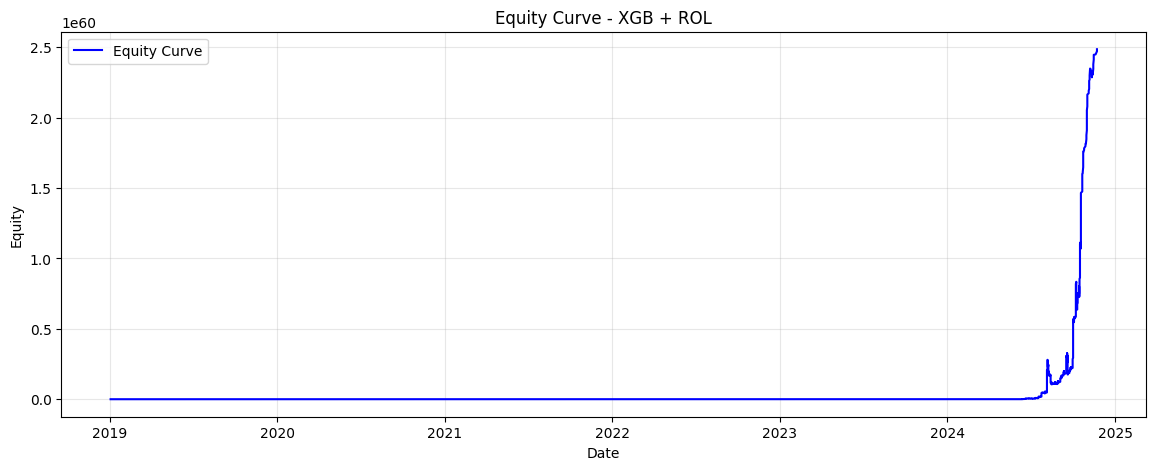

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

#Load data
df = pd.read_csv("/content/df_with_indicators_classification.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

#Feature Engineering
df["Price_Change"] = df["Close"].pct_change()
df["MA_Diff"] = df["MA_10"] - df["MA_30"]
df["EMA_Diff"] = df["EMA_10"] - df["EMA_30"]
df["BB_Position"] = (df["Close"] - df["BB_low"]) / (df["BB_high"] - df["BB_low"])
df["Volume_MA"] = df["Volume"] / df["Volume"].rolling(5).mean()
df["Volatility"] = df["Return"].rolling(10).std()
df["Momentum_5d"] = df["Close"] / df["Close"].shift(5) - 1

#Target
df["Target"] = (df["Return"].shift(-1) > 0).astype(int)
df = df.dropna().reset_index(drop=True)

feature_cols = [
    "Close","Volume","MA_10","MA_30","EMA_10","EMA_30",
    "BB_low","BB_high","Price_Change","MA_Diff","EMA_Diff",
    "BB_Position","Volume_MA","Volatility","Momentum_5d",
    "sentiment_continuous"
]

X = df[feature_cols].values
y = df["Target"].values
dates = df["Date"].values

#XGB
model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric="logloss",
    random_state=42,
    tree_method="hist"
)

pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", model)
])

#Walk-forward
tscv = TimeSeriesSplit(n_splits=5)
oof_probs = np.zeros(len(y))

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    pipeline.fit(
        X_train, y_train,
        model__eval_set=[(X_val, y_val)],
        model__verbose=False
    )
    oof_probs[val_idx] = pipeline.predict_proba(X_val)[:, 1]

#ROL
tau = 0.15   # confidence threshold
confidence = np.abs(oof_probs - 0.5)
trade_mask = confidence >= tau
pred_signal = np.where(trade_mask, (oof_probs > 0.5).astype(int), 0)

#Position sizing
# Simple flat position sizing (1 unit long/short)
position = 2*pred_signal - 1  # 1 for long, -1 for short/flat = 0

#Strategy returns
returns = df["Return"].values
strategy_returns = position * returns

#Equity curve
equity = np.cumprod(1 + strategy_returns)
peak = np.maximum.accumulate(equity)
drawdown = (equity - peak) / peak
max_dd = drawdown.min()

#Performance
sr = strategy_returns[strategy_returns != 0]
mean_ret = sr.mean()
vol_ret = sr.std()
sharpe = mean_ret / vol_ret * np.sqrt(252) if vol_ret != 0 else 0
downside = sr[sr < 0].std()
sortino = mean_ret / downside * np.sqrt(252) if downside != 0 else 0
hit_rate = (sr > 0).mean() if len(sr) > 0 else 0
avg_win = sr[sr > 0].mean() if len(sr[sr > 0]) > 0 else 0
avg_loss = sr[sr < 0].mean() if len(sr[sr < 0]) > 0 else 0
profit_factor = sr[sr > 0].sum() / abs(sr[sr < 0].sum()) if abs(sr[sr < 0].sum()) > 0 else np.nan
skew = ((sr - sr.mean())**3).mean() / (sr.std()**3) if sr.std() != 0 else 0
kurt = ((sr - sr.mean())**4).mean() / (sr.std()**4) if sr.std() != 0 else 0

#Statistical indicators
print("===== ENSEMBLE DIAGNOSTICS (XGB + ROL) =====")
print(f"Coverage                  : {trade_mask.mean():.2%}")
print(f"Sharpe Ratio              : {sharpe:.3f}")
print(f"Sortino Ratio             : {sortino:.3f}")
print(f"Max Drawdown              : {max_dd:.2%}")
print(f"Hit Rate                  : {hit_rate:.2%}")
print(f"Profit Factor             : {profit_factor:.2f}")
print(f"Avg Win / Loss            : {avg_win:.4f} / {avg_loss:.4f}")
print(f"Skew / Kurtosis           : {skew:.2f} / {kurt:.2f}")

#Equity
plt.figure(figsize=(14,5))
plt.plot(df["Date"], equity, label="Equity Curve", color="blue")
plt.title("Equity Curve - XGB + ROL")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


XGB + ROL is more aggressive, trading more often (86.7% coverage) and generating higher risk-adjusted returns (Sharpe 4.91, profit factor 2.34) with a higher hit rate (64%), but it comes with extreme downside risk (max drawdown -99.98%) and occasional very large losses or gains (high kurtosis 5.63). XGB + GARCH + ROL is more conservative, trading less frequently (72.4% coverage) with slightly lower Sharpe (3.83) and profit factor (1.69), a lower hit rate (61%), but better downside control (Sortino 8.63, max drawdown -98.8%) and more stable per-trade performance. In short, XGB + ROL aims for higher returns at the cost of extreme risk, while XGB + GARCH + ROL prioritizes steadier performance and controlled outcomes.

# References

1. Reddit Data in Quantitative Financial Models: Evolution and Implications Post GameStop and AMC Short Squeeze

Rohan Malhotra, Colin Jones (2025)

Reddit data (particularly from r/WallStreetBets) provide predictive information on: volatility, trading volumes, and short-term returns. Granger causality tests and VAR models show that Reddit activity anticipates trading volumes during speculative episodes (GameStop, AMC). The effect is strong for small-cap/meme stocks but diminishes sharply for large-cap stocks. Advanced NLP models (LSTM, custom lexicons, LDA) improve signal quality compared to generic sentiment. Significant limitations are highlighted: noise, slang, sarcasm, and ethical and regulatory issues.

2. A Tale of Company Fundamentals vs Sentiment-Driven Pricing: The Case of GameStop
Zeeshan Umar et al. (2021)


The price of GameStop during 2021 was largely disconnected from fundamentals. The impact of sentiment is inversely proportional to market capitalization and liquidity, peaking when short interest is high and market depth is low. For larger, more liquid stocks, sentiment has weak and temporary effects.


3. The Dynamics of the Reddit Collective Action Leading to the GameStop Short Squeeze

Desiderio, Aiello, Cimini, Alessandretti (2024)


Reddit played a measurable causal role in coordinating retail investors. Granger causality: Reddit → Volumes → Prices for meme stocks. For large-cap stocks, the influence is statistically weak and lasts less than 24 hours. There is a feedback loop: high trading generates further discussion on Reddit.



4. TweetEval: Unified Benchmark and Comparative Evaluation for Tweet Classification
Francesco Barbieri et al. (EMNLP 2020)


Introduction of TweetEval, a unified benchmark for 7 NLP tasks on Twitter: sentiment, emotion, hate, offensive, stance, irony, emoji. Transformer models (RoBERTa, BERT) significantly outperform SVMs and LSTMs. Pre-training on Twitter data further improves performance. Some tasks (irony, hate) remain challenging due to lack of context.

5. Findings of EMNLP 2020 – TweetEval Analysis

Barbieri et al. (2020)

Generalist models perform surprisingly well on Twitter. However, domain adaptation improves robustness and generalization. Irony and sarcasm are better captured by models natively trained on Twitter. Conversational context remains a critical variable not fully resolved.

6. Sentiment Analysis and Stock Prediction Using Twitter Data

Knoll et al. (2019)


Twitter sentiment predicts very short-term micro-trends (intraday / 1–2 days). Accuracy ≈ 71% for technology stocks. No evidence of long-term predictive ability.


7. Bots in the Twittersphere

Pew Research Center (2018)


Significant presence of bots and automated accounts on Twitter. This increases noise, manipulation risk, and introduces spurious signals in sentiment models.


8. XGBoost: A Scalable Tree Boosting System

Tianqi Chen, Carlos Guestrin (2016)

XGBoost is a scalable, high-performance system for ensemble learning with decision trees. Its strengths include being sparsity-aware: efficient handling of sparse data (missing values, one-hot encoding), which is very useful in our case. XGBoost also outperforms scikit-learn, R GBM, Spark MLlib, H2O in speed and accuracy. Used in 17 of 29 winning Kaggle solutions in 2015.

9. Stock Trend Prediction Using News Sentiment Analysis

Kalyani Joshi, Bharathi H. N., Jyothi Rao (2016)

Methodology: Data collection from Apple Inc. news (2013–2016) and historical stock prices. Data preparation for the encoder: stop word removal, stemming, tokenization. Classification: Comparison between Naive Bayes, Random Forest, and SVM. Evaluation: Accuracy, precision, recall, ROC curve, cross-validation, and testing on new data. An observable correlation exists between news sentiment and price movement.

10. Stock Price Prediction of Apple Inc. Using News Sentiment Analysis

S. Manjunatha, R. S. Pradeep Kumar (2018)





11. Machine Learning with a Reject Option: A survey
Hendrickx Kilian* · Perini Lorenzo* · Van
der Plas Dries · Meert Wannes · Davis Jesse
Received: 23 July 2021 / Revised: 27 July 2023 & 15 February 2024

As noted in the article mentioned, traditional ML models always make a prediction, even when they may be wrong. In critical domains such as medicine, engineering, and finance, errors can have serious consequences. The reject option enables a model to improve the accuracy of accepted predictions, increase user trust, save time by delegating difficult cases to human experts, and reduce bias and unfairness in predictions.